In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.set_option('display.float_format', lambda x: f'{x:.5f}')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
os.chdir(r'F:\cga\桌面\dataset\creditcard_fraud_detection')
data = pd.read_csv('creditcard.csv')

In [6]:
# 特征衍生
data['Hour'] = data['Time'].map(lambda x: np.ceil(float(x) / 3600) % 24)
data.drop('Time', axis=1, inplace=True)

In [5]:
def model_eval(y_test, y_pred, y_pred_prob):
    # 模型评价
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    p, r, _ = precision_recall_curve(y_test, y_pred_prob)
    print('KS:', max(tpr - fpr))
    print('roc_auc:', auc(fpr, tpr))
    print('pr_auc:', auc(r, p))
    print('average_precision_score:', average_precision_score(y_test, y_pred_prob))
    print('classification_report:\n', classification_report(y_test, y_pred))
    print('confusion_matrix:\n', confusion_matrix(y_test, y_pred))
    return

In [14]:
# 特征与目标列
X = data.drop('Class', axis=1)
y = data['Class']

In [13]:
# 原始数据划分训练集与测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [161]:
# 默认参数的RandomForest训练模型
RF = RandomForestClassifier(n_estimators=50, n_jobs=-1)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
y_pred_prob = RF.predict_proba(X_test)[:, 1]
model_eval(y_test, y_pred, y_pred_prob)

KS: 0.8726568717793769
roc_auc: 0.9429854472844372
pr_auc: 0.8558641737469252
average_precision_score: 0.8479258571121386
classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85309
           1       0.93      0.81      0.86       134

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443

confusion_matrix:
 [[85301     8]
 [   26   108]]


In [54]:
# 交叉验证f1平均分和变异系数
def plot_f1mean_cov(f1_mean, cov, param, min_value=None, max_value=None, param_list=None):
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    if param_list:
        xticks = range(len(param_list))
    else:
        xticks = range(min_value, max_value)
    ax1.plot(xticks, f1_mean)
    ax1.set_title('f1 score with different %s' % param, fontsize=20)
    ax1.set_xlabel(param, fontsize=16)
    ax1.set_ylabel('f1 score', fontsize=16)
    if param_list:
        plt.xticks(range(len(param_list)), param_list)
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(xticks, cov)
    ax2.set_title('cov with different %s' % param, fontsize=20)
    ax2.set_xlabel(param, fontsize=16)
    ax2.set_ylabel('cov', fontsize=16)
    if param_list:
        plt.xticks(range(len(param_list)), param_list)  # 不能用ax1.xticks
    plt.show()

In [ ]:
# 比较不同参数下的f1_score和cov
def f1mean_cov(param_name, fixed_params, min_param=None, max_param=None, param_list=None):
    f1_mean = []
    cov = []  # coefficient of variation
    kfold = StratifiedKFold(n_splits=5, random_state=2)
    if not param_list:
        param_list = range(min_param, max_param)
    for i in param_list:
        f1_results = cross_val_score(RandomForestClassifier(vars()[param_name]=i, n_jobs=-1, fixed_params),
                                     X_train, y_train, scoring='f1', cv=kfold, n_jobs=-1)
        f1_mean.append(np.mean(f1_results))
        cov.append(np.std(f1_results) / np.mean(f1_results))
    return f1_mean, cov

In [114]:
# sub-sample
bad = np.hstack((X_train[y_train == 1].values, y_train[y_train == 1].values.reshape(358, 1)))
good = np.hstack((X_train[y_train == 0].values, y_train[y_train == 0].values.reshape(199006, 1)))
np.random.shuffle(good)
subsample = np.vstack((bad, good[:492 * 3,]))
np.random.shuffle(subsample)
X_train_sub = subsample[:, :-1]
y_train_sub = subsample[:, -1]

199006


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


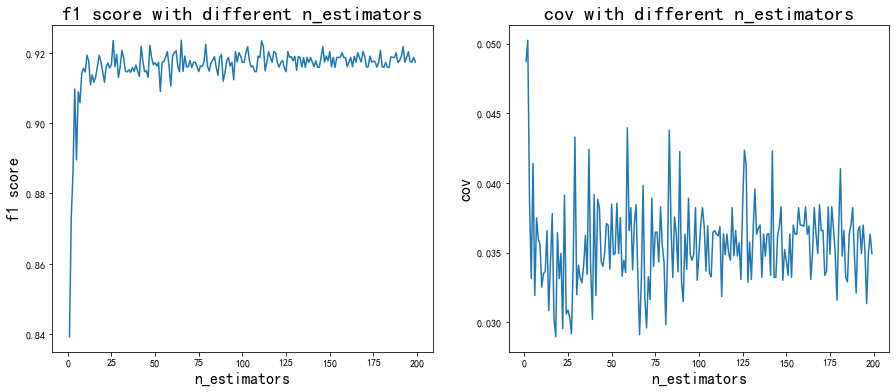

In [115]:
# RandomForest调参
# param1: n_estimators，40以上f1_score和cov较稳定
f1_mean = []
cov = []  # coefficient of variation
kfold = StratifiedKFold(n_splits=10, random_state=2)
for i in range(1, 200):
    f1_results = cross_val_score(RandomForestClassifier(n_estimators=i, n_jobs=-1), X_train_sub, y_train_sub, scoring='f1', cv=kfold, n_jobs=-1)
    f1_mean.append(np.mean(f1_results))
    cov.append(np.std(f1_results) / np.mean(f1_results))
plot_f1mean_cov(f1_mean, cov, 'n_estimators', 1, 200)

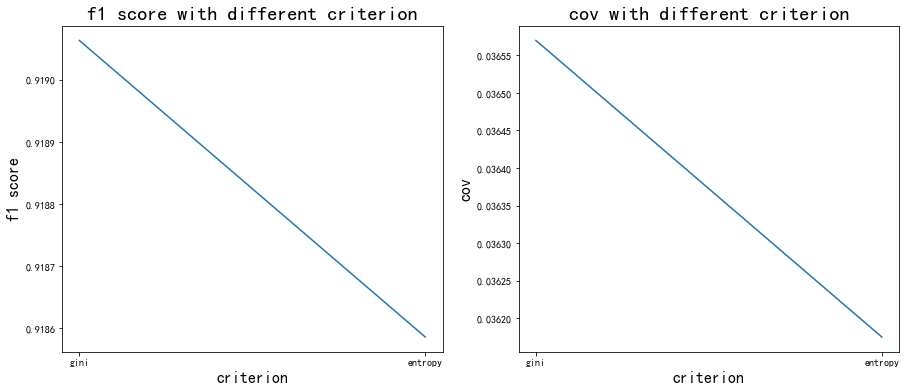

In [117]:
# param2：criterion:gini和entropy，gini--CART决策树，entropy--ID3
param_name = 'criterion'
param_list=['gini', 'entropy']
f1_mean = []
cov = []  # coefficient of variation
kfold = StratifiedKFold(n_splits=10, random_state=2)
for i in param_list:
    f1_results = cross_val_score(RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion=i),
                                 X_train_sub, y_train_sub, scoring='f1', cv=kfold, n_jobs=-1)
    f1_mean.append(np.mean(f1_results))
    cov.append(np.std(f1_results) / np.mean(f1_results))
plot_f1mean_cov(f1_mean, cov, param_name, param_list=param_list)

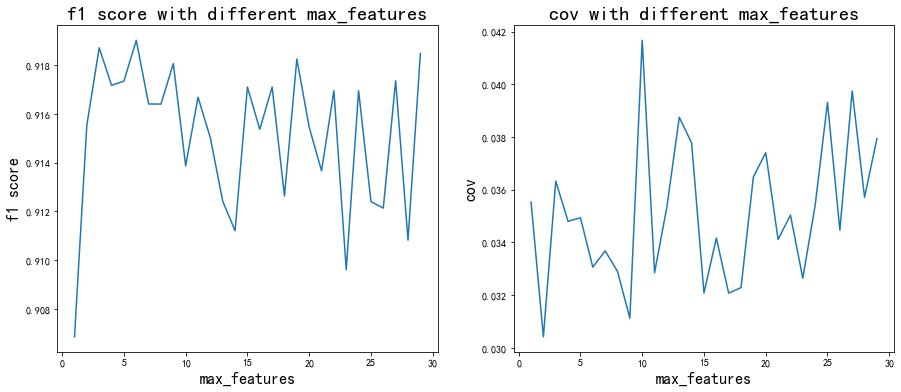

In [118]:
# param3：max_features,
param_name = 'max_features'
min_param = 1
max_param = 30
f1_mean = []
cov = []  # coefficient of variation
kfold = StratifiedKFold(n_splits=10, random_state=2)
for i in range(min_param, max_param):
    f1_results = cross_val_score(RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_features=i),
                                 X_train_sub, y_train_sub, scoring='f1', cv=kfold, n_jobs=-1)
    f1_mean.append(np.mean(f1_results))
    cov.append(np.std(f1_results) / np.mean(f1_results))
plot_f1mean_cov(f1_mean, cov, param_name, min_value=1, max_value=30)

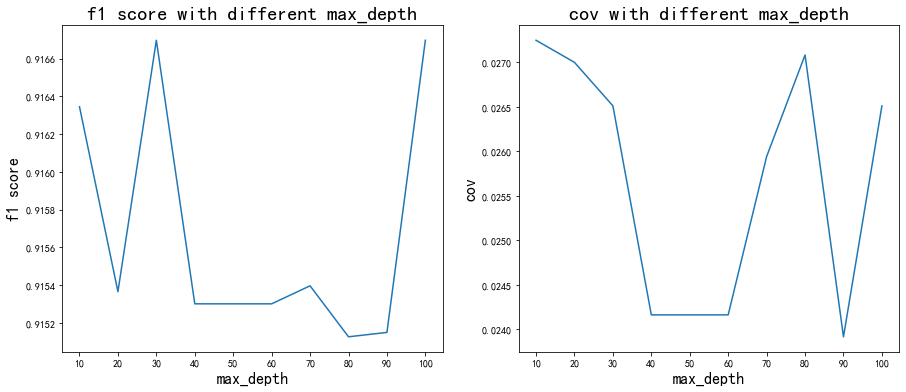

In [120]:
# param4：max_depth,
param_name = 'max_depth'
min_param = 10
max_param = 101
f1_mean = []
cov = []  # coefficient of variation
kfold = StratifiedKFold(n_splits=5, random_state=2)
for i in range(min_param, max_param, 10):
    f1_results = cross_val_score(RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_depth=i),
                                 X_train_sub, y_train_sub, scoring='f1', cv=kfold, n_jobs=-1)
    f1_mean.append(np.mean(f1_results))
    cov.append(np.std(f1_results) / np.mean(f1_results))
plot_f1mean_cov(f1_mean, cov, param_name, param_list=range(10, 101, 10))

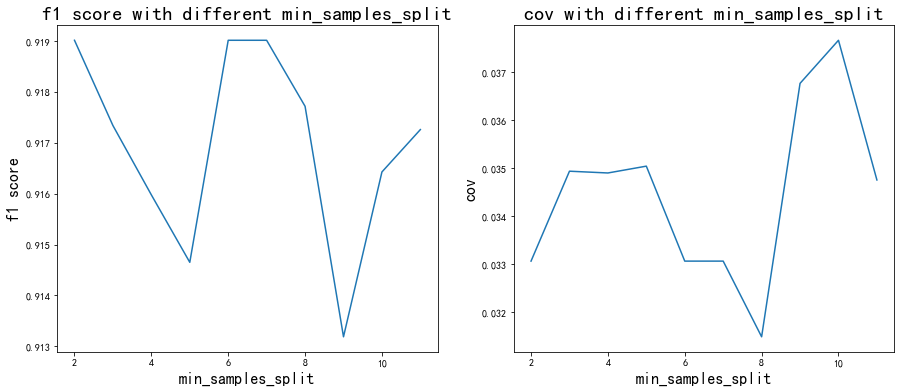

In [123]:
# param5：min_samples_split
param_name = 'min_samples_split'
min_param = 2
max_param = 12
f1_mean = []
cov = []  # coefficient of variation
kfold = StratifiedKFold(n_splits=10, random_state=2)
for i in range(min_param, max_param):
    f1_results = cross_val_score(RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', min_samples_split=i),
                                 X_train_sub, y_train_sub, scoring='f1', cv=kfold, n_jobs=-1)
    f1_mean.append(np.mean(f1_results))
    cov.append(np.std(f1_results) / np.mean(f1_results))
plot_f1mean_cov(f1_mean, cov, param_name, min_value=2, max_value=12)

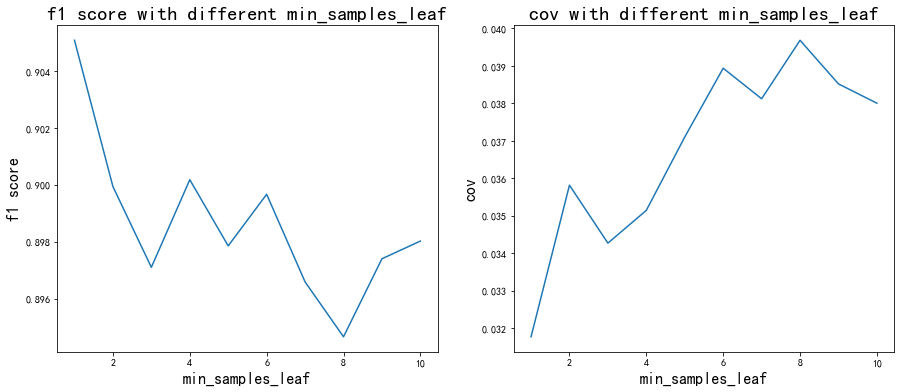

In [105]:
# param6：min_samples_leaf
param_name = 'min_samples_leaf'
min_param = 1
max_param = 11
f1_mean = []
cov = []  # coefficient of variation
kfold = StratifiedKFold(n_splits=10, random_state=2)
for i in range(min_param, max_param):
    f1_results = cross_val_score(RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', min_samples_leaf=i),
                                 X_train_sub, y_train_sub, scoring='f1', cv=kfold, n_jobs=-1)
    f1_mean.append(np.mean(f1_results))
    cov.append(np.std(f1_results) / np.mean(f1_results))
plot_f1mean_cov(f1_mean, cov, param_name, min_value=1, max_value=11)

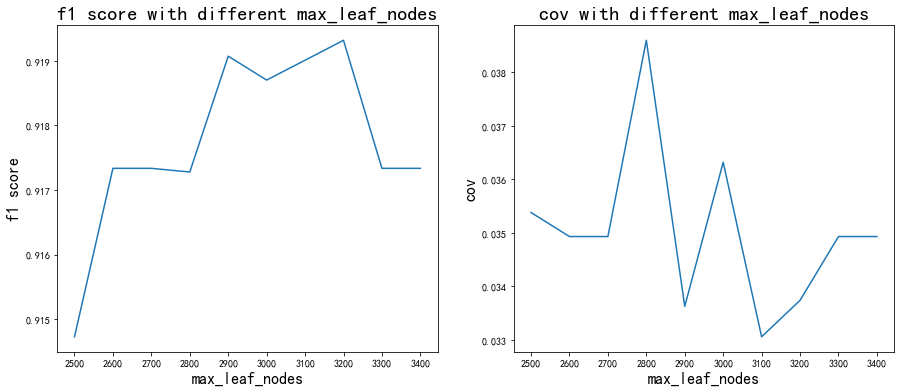

In [125]:
# param7：max_leaf_nodes
param_name = 'max_leaf_nodes'
min_param = 2500
max_param = 3500
f1_mean = []
cov = []  # coefficient of variation
kfold = StratifiedKFold(n_splits=10, random_state=2)
for i in range(min_param, max_param, 100):
    f1_results = cross_val_score(RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_leaf_nodes=i),
                                 X_train_sub, y_train_sub, scoring='f1', cv=kfold, n_jobs=-1)
    f1_mean.append(np.mean(f1_results))
    cov.append(np.std(f1_results) / np.mean(f1_results))
plot_f1mean_cov(f1_mean, cov, param_name, param_list=range(2500, 3500, 100))

In [157]:
LR = RandomForestClassifier(n_jobs=-1)
LR.fit(X_train_sub, y_train_sub)
y_pred = LR.predict(X_test)
y_pred_prob = LR.predict_proba(X_test)[:, 1]
model_eval(y_test, y_pred, y_pred_prob)


KS: 0.8882898569082404
roc_auc: 0.970258339175426
pr_auc: 0.7865695774930768
average_precision_score: 0.7256084086452866
classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85309
           1       0.30      0.87      0.44       134

    accuracy                           1.00     85443
   macro avg       0.65      0.93      0.72     85443
weighted avg       1.00      1.00      1.00     85443

confusion_matrix:
 [[85031   278]
 [   17   117]]


In [150]:
LR = RandomForestClassifier(n_jobs=-1, n_estimators=50)
LR.fit(X_train_sub, y_train_sub)
y_pred = LR.predict(X_test)
y_pred_prob = LR.predict_proba(X_test)[:, 1]
model_eval(y_test, y_pred, y_pred_prob)

KS: 0.8934347183539803
roc_auc: 0.9761618999447662
pr_auc: 0.7944783037893339
average_precision_score: 0.753885448150552
classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85309
           1       0.26      0.88      0.40       134

    accuracy                           1.00     85443
   macro avg       0.63      0.94      0.70     85443
weighted avg       1.00      1.00      1.00     85443

confusion_matrix:
 [[84977   332]
 [   16   118]]
